# Traveling Salesperson Problem

In [8]:
from utils import make_tsp_qp, randomize_cities, brute_force_tsp, draw_tour, reorder

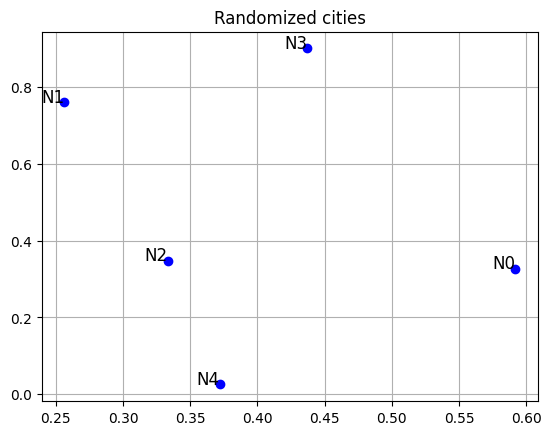

array([[0, 5, 2, 5, 3],
       [5, 0, 4, 2, 7],
       [2, 4, 0, 5, 3],
       [5, 2, 5, 0, 8],
       [3, 7, 3, 8, 0]])

In [9]:
# Create a random TSP problem
weights = randomize_cities(5)
weights

## Brute force solve

Best order from brute force = (0, 3, 1, 2, 4) with total distance = 17


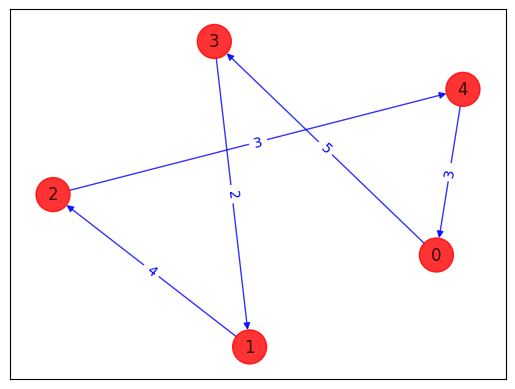

In [10]:
best_order, best_distance = brute_force_tsp(weights)
draw_tour(weights, best_order)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)

## Formulating QUBO

For $N$ cities, use $N^2$ binary variables x(i,p), where i represents the index of a city and p represents the order of the city in the route. In other words, if city i is visited at step p of the route, then x(i,p) = 1.

Constraints\
This euations ensure that each city is visited only once, and each step of the route is in one city.
$
\begin{gather}
\sum_{p=0}^{N-1} ( 1 - \sum_{i=0}^{N-1} x(i, p) )^2 = 0 \\
\sum_{i=0}^{N-1} ( 1 - \sum_{p=0}^{N-1} x(i, p) )^2 = 0 \\ 
\sum_{i=0}^{N-1} x_{i, p} = 1,\ for\ all\ p \\
\sum_{p=0}^{N-1} x_{i, p} = 1,\ for\ all\ i \\
\end{gather}
$

Objective\
Find the shortest Hamiltonian cycle in a graph
$
\begin{gather}
C(x) = \sum_{i, j} w_{i, j} \sum_{p=0}^{N-1} x_{i, p}x_{j, p + 1}  \\
\end{gather}
$

In [11]:
from qiskit_optimization.converters import QuadraticProgramToQubo

# making quadratic program from TSP weights
quadratic_program = make_tsp_qp(weights)
# conveerts the quadratic program to QUBO, with a penalty of 10 (constant to scale the constraints)
qp2qubo = QuadraticProgramToQubo(penalty=10)
qubo = qp2qubo.convert(quadratic_program)
# converts the QUBO to an Ising Hamiltonian
qubitOp, offset = qubo.to_ising()

print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 15545.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIIZIIIIIZ', 'IIIIIIIIIIIIIIIZIIIIIIIIZ', 'IIIIIIIIIIIIIIZIIIIII

## Classical Solver

In [12]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver


# 4 cities and above crashes the kernel
# exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
# result = exact.solve(qubo)
# print(result.prettyprint())


## Running on quantum computer

In [13]:
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_algorithms import QAOA

from qiskit_aer.primitives import Sampler

optimizer = L_BFGS_B(maxiter=300) # L_BFGS_B optimizer is used for its efficiency in terms of required evaluations of the objective functions, noiselless case

# QAOA measurement object
qaoa_mes = QAOA(sampler=Sampler(), optimizer=optimizer, reps=1)
# exact_mes = NumPyMinimumEigensolver()

# QAOA and exact classical minimum eigen solver optimizers
qaoa = MinimumEigenOptimizer(qaoa_mes) # using the QAOA
# exact = MinimumEigenOptimizer(exact_mes) # using the exact classical numpy minimum eigen solver

# exact_result = exact.solve(qubo)
# print(exact_result.prettyprint())

qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

# 5 cities: 6 mins on GPU

objective function value: 2665.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_0_4=1.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_1_3=0.0, x_1_4=0.0, x_2_0=1.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_2_4=0.0, x_3_0=0.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0, x_3_4=0.0, x_4_0=1.0, x_4_1=0.0, x_4_2=0.0, x_4_3=0.0, x_4_4=0.0
status: SUCCESS


In [14]:
reorder(qaoa_result.x, len(weights))

array([4., 2., 0., 0., 0.])